In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [2]:
import equinox as eqx
from module.module import Module

In [3]:
# Hyperparameters

BATCH_SIZE = 1
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 30
SEED = 5678

In [4]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [5]:
layer = Module(
    eqx.nn.Linear(
        in_features=28*28,
        out_features=1024,
        key=jr.PRNGKey(SEED)
    )
)

print(layer)

Module(
  _layer=Linear(
    weight=f32[1024,784],
    bias=f32[1024],
    in_features=784,
    out_features=1024,
    use_bias=True
  ),
  _activation=<function <lambda>>,
  _goodness_fn=<function <lambda>>,
  _opt_state=None
)


In [6]:
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # BATCH_SIZEx1x28x28
print(dummy_y.shape)  # BATCH_SIZE
print(dummy_y)

(1, 1, 28, 28)
(1,)
[7]


In [7]:
def overlay_y_on_x(x: Array, y: Array):
    """
    Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = jnp.ravel(x)
    x_ = x_.at[:10].set(jnp.zeros((10,)))
    x_ = x_.at[y.item()].set(1)

    return x_.reshape(x.shape)


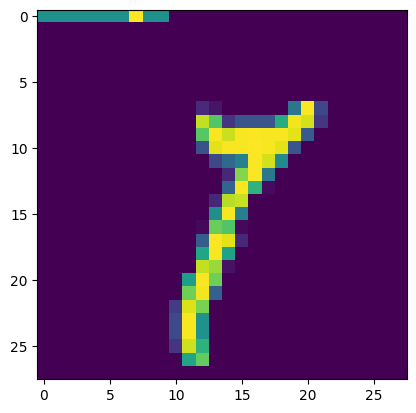

In [8]:
import numpy as np
from matplotlib import pyplot as plt

def one_hot(y: Array):
    r = jnp.zeros((10,), dtype=jnp.int32)
    r.at[y.item()].set(1)

    return r

plt.imshow(overlay_y_on_x(np.squeeze(dummy_x), dummy_y))
plt.show()

In [9]:
out_1 = layer.forward(np.ravel(dummy_x))
goodness = layer.goodness(np.ravel(dummy_x))

print(out_1.shape)
print(out_1)
print()
print(goodness)

(1024,)
[ 0.13575944 -0.35504067  0.9685119  ...  1.1571106   0.16411908
  0.37432992]

0.3129891


In [10]:
# Single layer example

opt = optax.adam(LEARNING_RATE)

for _ in range(10):
    out, layer = layer.train_step(
        np.ravel(dummy_x),
        True,
        opt
    )

    g, y = out
    print(g)

0.3129891
0.56178916
0.90294
1.3399609
1.8753643
2.5121024
3.2534463
4.102888
5.0640936
6.140852
